**MSc Final Project**

Inherited Retinal Disease Literature Summarisation using Transformers
Summarisation

In [1]:
# !python -m spacy download en_core_web_md

In [2]:
# !pip install transformers

In [3]:
import torch
torch.cuda.empty_cache() 

In [4]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# !pip install torch

In [6]:
import os
import re
import torch
import transformers
import spacy
from spacy.tokens import Span
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_sci_md")

# if not Span.has_extension("kb_ents"):
#     Span.set_extension("kb_ents", default=[], force=True)

/home/skanda/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/skanda/.local/lib/python3.10/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


## **1. Loading Seperated Abstracts and Main Texts**

In [7]:
def load_preprocessed_data(directory):
    
    abstracts = []
    main_texts = []
    filenames = []

    # Loop through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('_abstract.txt'):
            # Get the base filename without the '_abstract.txt' suffix
            base_filename = filename.replace('_abstract.txt', '')

            # Identify potential matching main text file(s)
            possible_main_text_files = [
                f for f in os.listdir(directory)
                if f.startswith(base_filename) and f.endswith('_main_text.txt')
            ]

            if possible_main_text_files:
                # Load the abstract
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                    abstract = file.read().strip()
                    abstracts.append(abstract)

                # Load the corresponding main text
                main_text_file = possible_main_text_files[0]
                with open(os.path.join(directory, main_text_file), 'r', encoding='utf-8') as file:
                    main_text = file.read().strip()
                    main_texts.append(main_text)

                # Store the base filename for reference
                filenames.append(base_filename)
            else:
                print(f"Warning: No corresponding main text file found for {filename}.")
    
    print(f"Loaded {len(abstracts)} preprocessed documents.")
    return abstracts, main_texts, filenames

In [8]:
from sklearn.model_selection import train_test_split

def split_data(abstracts, main_texts, filenames, test_size=0.33, val_size=0.5, random_state=42):
    """
    Split the data into training, validation, and test sets.
    
    :param abstracts: List of abstracts
    :param main_texts: List of main texts
    :param filenames: List of filenames
    :param test_size: Proportion of the dataset to include in the test split
    :param val_size: Proportion of the remaining dataset to include in the validation split
    :param random_state: Random state for reproducibility
    :return: train_data, validation_data, test_data
    """
    # Combine abstracts, main_texts, and filenames into a single list of tuples
    combined_data = list(zip(abstracts, main_texts, filenames))
    
    # First split: Separate the test set
    remaining_data, test_data = train_test_split(combined_data, test_size=test_size, random_state=random_state)
    
    # Second split: Split the remaining data into training and validation sets
    train_data, validation_data = train_test_split(remaining_data, test_size=val_size, random_state=random_state)
    
    print(f"Total number of papers: {len(combined_data)}")
    print(f"Number of papers in training set: {len(train_data)}")
    print(f"Number of papers in validation set: {len(validation_data)}")
    print(f"Number of papers in test set: {len(test_data)}")
    
    return train_data, validation_data, test_data


In [9]:
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    LEDTokenizer, LEDForConditionalGeneration
)
import torch

def load_model(model_name, device):
    """
    Loads the appropriate model and tokenizer based on the model_name.
    """
    if model_name == "t5-large":
        tokenizer = T5Tokenizer.from_pretrained(model_name)
        model = T5ForConditionalGeneration.from_pretrained(model_name)
    elif model_name == "bart-large-cnn":
        tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
        model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
    elif model_name == "led-large-16384":
        tokenizer = LEDTokenizer.from_pretrained("allenai/led-large-16384")
        model = LEDForConditionalGeneration.from_pretrained("allenai/led-large-16384")
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    model.to(device)
    return model, tokenizer

## **2. Generating Summaries**

In [10]:
def generate_summary(model, tokenizer, text, device, 
                     max_length= 512,  # Increased from 512 to 1024
                     min_length=100, 
                     num_beams=4, 
                     truncate=True, 
                     max_input_length=1024,  # Increased from 1024 to 2048
                     length_penalty=1.0):
    """
    Generates a summary for the given text using the provided model and tokenizer.
    """
    try:
        # Prepare input text
        if isinstance(tokenizer, T5Tokenizer):
            input_text = "summarize: " + text
        else:
            input_text = text
        
        # Tokenize input text, with optional truncation
        input_ids = tokenizer.encode(
            input_text, 
            return_tensors="pt", 
            truncation=truncate, 
            max_length=max_input_length if truncate else None
        )
        input_ids = input_ids.to(device)
        
        # Generate the summary
        summary_ids = model.generate(
            input_ids,
            max_length=max_length,  # Adjusted max_length
            min_length=min_length,  # Adjusted min_length
            length_penalty=length_penalty,  # Pass the length_penalty here
            num_beams=num_beams,
            early_stopping=True,
        )
        
        # Decode the generated tokens into a summary with clean_up_tokenization_spaces applied
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        return summary

    except Exception as e:
        print(f"Error in generating summary: {str(e)}")
        return ""


## **Extracting and Comparing UML Entities**

In [11]:
""" 
summary_entities = []
entities_path = "/mnt/scratch/skanda/MSc_IRD_LLM/data/Entities/"

def extract_umls_entities(summary):
    doc = nlp(summary)
    entities = []
    for ent in doc.ents:
        if ent._.kb_ents:
            top_concept = ent._.kb_ents[0]
            entities.append({
                "text": ent.text,
                "label": ent.label_,
                "concept_id": top_concept[0],
                "score": top_concept[1],
                "start": ent.start_char,
                "end": ent.end_char
            })
        else:
            # Log or print entities without UMLS linking for debugging
            print(f"Entity '{ent.text}' with label '{ent.label_}' has no UMLS concepts linked.")
    return entities


def compare_entities(abstract_entities, summary_entities):
    abstract_concepts = set(entity['concept_id'] for entity in abstract_entities)
    summary_concepts = set(entity['concept_id'] for entity in summary_entities)
    
    true_positives = len(abstract_concepts.intersection(summary_concepts))
    false_positives = len(summary_concepts - abstract_concepts)
    false_negatives = len(abstract_concepts - summary_concepts)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "common_entities": list(abstract_concepts.intersection(summary_concepts)),
        "missed_entities": list(abstract_concepts - summary_concepts),
        "extra_entities": list(summary_concepts - abstract_concepts)
    }

"""

' \nsummary_entities = []\nentities_path = "/mnt/scratch/skanda/MSc_IRD_LLM/data/Entities/"\n\ndef extract_umls_entities(summary):\n    doc = nlp(summary)\n    entities = []\n    for ent in doc.ents:\n        if ent._.kb_ents:\n            top_concept = ent._.kb_ents[0]\n            entities.append({\n                "text": ent.text,\n                "label": ent.label_,\n                "concept_id": top_concept[0],\n                "score": top_concept[1],\n                "start": ent.start_char,\n                "end": ent.end_char\n            })\n        else:\n            # Log or print entities without UMLS linking for debugging\n            print(f"Entity \'{ent.text}\' with label \'{ent.label_}\' has no UMLS concepts linked.")\n    return entities\n\n\ndef compare_entities(abstract_entities, summary_entities):\n    abstract_concepts = set(entity[\'concept_id\'] for entity in abstract_entities)\n    summary_concepts = set(entity[\'concept_id\'] for entity in summary_entities)

## **Evaluating Summaries**

In [12]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

def evaluate_summary(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    return bleu_score, rouge_scores


## **Processing papers**

In [13]:
from tqdm import tqdm
import torch

def process_papers(model_name, preprocessed_data, reference_summaries, filenames, num_beams=4):
    assert len(preprocessed_data) == len(reference_summaries), "Mismatch between number of papers and abstracts"
    
    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model and tokenizer based on model_name
    model, tokenizer = load_model(model_name, device=device)
    
    summaries = []
    bleu_scores = []
    rouge_scores_list = []
  
    for doc, ref, filename in tqdm(zip(preprocessed_data, reference_summaries, filenames), total=len(preprocessed_data)):
        if not ref:
            print(f"Skipping document with no abstract: {doc[:30]}...")
            continue
        
        # Generate summary
        summary = generate_summary(
            model=model,
            tokenizer=tokenizer,
            text=doc,
            device=device,
            num_beams=num_beams
        )
        
        # Evaluate the generated summary
        bleu, rouge = evaluate_summary(ref, summary)
        
        # Append results
        summaries.append(summary)
        bleu_scores.append(bleu)
        rouge_scores_list.append(rouge)
    
    return summaries, bleu_scores, rouge_scores_list


## **Saving the Results**

In [14]:
def save_results(summaries, 
                 bleu_scores, 
                 rouge_scores, 
                 filenames, 
                 results_dir):
    
    os.makedirs(results_dir, exist_ok=True)
    
    summaries_file = os.path.join(results_dir, 'summaries.txt')
    with open(summaries_file, 'w', encoding='utf-8') as f:
        for filename, summary in zip(filenames, summaries):
            f.write(f"Document: {filename}\n")
            f.write(summary + '\n\n')
    print(f"Summaries saved to {summaries_file}")
    
    scores_file = os.path.join(results_dir, 'scores.txt')
    with open(scores_file, 'w', encoding='utf-8') as f:
        for filename, bleu, rouge in zip(filenames, bleu_scores, rouge_scores):
            f.write(f"Document: {filename}\n")
            f.write(f"BLEU Score: {bleu:.4f}\n")
            f.write(f"ROUGE Scores: {rouge}\n")
    print(f"Scores saved to {scores_file}")


## **Evaluating the Models**

In [15]:
import os
import numpy as np
from tqdm import tqdm

def evaluate_models(model_names, validation_abstracts, validation_texts, validation_filenames, results_dir, num_beams=4):
    model_scores_dict = {}

    print(f"Loaded {len(validation_abstracts)} abstracts and {len(validation_texts)} main texts for validation.")

    for model_name in model_names:
        print(f"Evaluating model: {model_name} with num_beams={num_beams}")

        try:
            # Process data: Generate summaries without passing device
            summaries, bleu_scores, rouge_scores_list = process_papers(
                model_name, validation_texts, validation_abstracts, validation_filenames, num_beams=num_beams
            )

            # Store the scores in the dictionary
            experiment_name = f"{model_name}_num_beams_{num_beams}"
            model_scores_dict[experiment_name] = (bleu_scores, rouge_scores_list)

            # Save results
            model_results_dir = os.path.join(results_dir, experiment_name.replace("/", "_"))
            save_results(summaries, bleu_scores, rouge_scores_list, validation_filenames, model_results_dir)
        
        except Exception as e:
            print(f"Error processing model {model_name}: {str(e)}")
            continue

    # Select the best performing models
    best_models = select_best_models(model_scores_dict)

    print("\nBest performing models:")
    for metric, (best_model, best_score) in best_models.items():
        print(f"Best {metric.upper()} Score Model: {best_model} with an average {metric.upper()} score of {best_score:.4f}")

    return model_scores_dict



def select_best_models(model_scores_dict):
    best_models = {}
    
    for experiment_name, (bleu_scores, rouge_scores_list) in model_scores_dict.items():
        # Calculate the average BLEU score
        avg_bleu = sum(bleu_scores) / len(bleu_scores)
        
        # Calculate the average ROUGE scores
        avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores_list]) / len(rouge_scores_list)
        avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores_list]) / len(rouge_scores_list)
        avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores_list]) / len(rouge_scores_list)
        
        # Calculate the combined average score
        avg_combined_score = (avg_bleu + avg_rouge1 + avg_rouge2 + avg_rougeL) / 4.0

        # Store the best model for the combined metric
        if 'combined' not in best_models or best_models['combined'][1] < avg_combined_score:
            best_models['combined'] = (experiment_name, avg_combined_score)
    
    return best_models



In [16]:
# # Call evaluate_models to get model_scores_dict
# model_scores_dict = evaluate_models(
#     model_names=model_names,
#     dev_abstracts=dev_abstracts,
#     dev_texts=dev_texts,
#     dev_filenames=dev_filenames,
#     results_dir=results_dir,
#     num_beams=4
# )


## **Plotting the Results**

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bleu_scores(model_scores_dict):
    plt.figure(figsize=(10, 6))

    # Plot BLEU Scores
    for model_name, (bleu_scores, rouge_scores_list) in model_scores_dict.items():
        num_documents = len(bleu_scores)
        plt.plot(range(num_documents), bleu_scores, marker='o', linestyle='-', label=f'{model_name.split("_")[0]} BLEU')
        # Print BLEU scores for each document
        print(f"{model_name.split('_')[0]} BLEU Scores: {bleu_scores}")
    
    plt.xlabel('Document Index')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Scores for Summarized Documents Across Models', fontweight='bold')
    plt.grid(True)

    # Create a unique legend for BLEU scores
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

def plot_rouge_scores(model_scores_dict):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    # Determine the number of documents
    num_documents = len(next(iter(model_scores_dict.values()))[1])

    for model_name, (bleu_scores, rouge_scores_list) in model_scores_dict.items():
        rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores_list]
        rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores_list]
        rougel_scores = [score['rougeL'].fmeasure for score in rouge_scores_list]

        axes[0].plot(range(num_documents), rouge1_scores, marker='o', linestyle='-', alpha=0.6, label=f'{model_name.split("_")[0]} ROUGE-1')
        axes[1].plot(range(num_documents), rouge2_scores, marker='o', linestyle='-', alpha=0.6, label=f'{model_name.split("_")[0]} ROUGE-2')
        axes[2].plot(range(num_documents), rougel_scores, marker='o', linestyle='-', alpha=0.6, label=f'{model_name.split("_")[0]} ROUGE-L')

    for i, metric in enumerate(['ROUGE-1', 'ROUGE-2', 'ROUGE-L']):
        axes[i].set_xlabel('Document Index')
        axes[i].set_ylabel(f'{metric} Score')
        axes[i].set_title(f'{metric} Scores for Summarized Documents Across Models', fontweight='bold')
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# # Assuming `model_scores_dict` is already defined with your BLEU and ROUGE scores
# plot_bleu_scores(model_scores_dict)
# plot_rouge_scores(model_scores_dict)


In [18]:
# !pip install seaborn

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_scores(model_scores_dict):
    plt.figure(figsize=(20, 15))
    sns.set_style("whitegrid")
    
    # Prepare data for box plots
    bleu_data = []
    rouge1_data = []
    rouge2_data = []
    rougel_data = []
    model_names = []

    for model_name, (bleu_scores, rouge_scores_list) in model_scores_dict.items():
        bleu_data.append(bleu_scores)
        rouge1_data.append([score['rouge1'].fmeasure for score in rouge_scores_list])
        rouge2_data.append([score['rouge2'].fmeasure for score in rouge_scores_list])
        rougel_data.append([score['rougeL'].fmeasure for score in rouge_scores_list])
        model_names.append(model_name.split("_")[0])  # Assuming format "model_name_num_beams_x"

    # Plot BLEU Scores
    plt.subplot(2, 2, 1)
    sns.boxplot(data=bleu_data, palette="Set3")
    plt.title('BLEU Scores Distribution Across Models', fontweight='bold')
    plt.ylabel('BLEU Score')
    plt.xticks(range(len(model_names)), model_names, rotation=45)

    # Plot ROUGE-1 Scores
    plt.subplot(2, 2, 2)
    sns.boxplot(data=rouge1_data, palette="Set3")
    plt.title('ROUGE-1 Scores Distribution Across Models', fontweight='bold')
    plt.ylabel('ROUGE-1 Score')
    plt.xticks(range(len(model_names)), model_names, rotation=45)

    # Plot ROUGE-2 Scores
    plt.subplot(2, 2, 3)
    sns.boxplot(data=rouge2_data, palette="Set3")
    plt.title('ROUGE-2 Scores Distribution Across Models', fontweight='bold')
    plt.ylabel('ROUGE-2 Score')
    plt.xticks(range(len(model_names)), model_names, rotation=45)

    # Plot ROUGE-L Scores
    plt.subplot(2, 2, 4)
    sns.boxplot(data=rougel_data, palette="Set3")
    plt.title('ROUGE-L Scores Distribution Across Models', fontweight='bold')
    plt.ylabel('ROUGE-L Score')
    plt.xticks(range(len(model_names)), model_names, rotation=45)

    plt.tight_layout()
    plt.show()

    # Calculate and print average scores
    print("\nAverage Scores:")
    for i, model_name in enumerate(model_names):
        print(f"\n{model_name}:")
        print(f"  BLEU: {np.mean(bleu_data[i]):.4f} (±{np.std(bleu_data[i]):.4f})")
        print(f"  ROUGE-1: {np.mean(rouge1_data[i]):.4f} (±{np.std(rouge1_data[i]):.4f})")
        print(f"  ROUGE-2: {np.mean(rouge2_data[i]):.4f} (±{np.std(rouge2_data[i]):.4f})")
        print(f"  ROUGE-L: {np.mean(rougel_data[i]):.4f} (±{np.std(rougel_data[i]):.4f})")



In [20]:
def tune_hyperparameters(best_model_name, train_texts, validation_texts, device):
    try:
        # Extract model name and number of beams
        model_name = best_model_name.split('_')[0]  
        initial_num_beams = int(best_model_name.split('_')[-1])  # Get the last part as num_beams
    except ValueError:
        raise ValueError("The best_model_name does not contain a valid number of beams.")

    best_num_beams = initial_num_beams
    best_length_penalty = 1.0  # Starting with the default length penalty
    best_score = -1
    param_tuned_model = None

    # Load the model and tokenizer once
    model, tokenizer = load_model(model_name, device)

    # Loop over different values for num_beams and length_penalty
    for num_beams in [2, 4, 6]:  # Example values
        for length_penalty in [0.8, 1.0, 1.2]:  # Example values
            
            print(f"Evaluating with num_beams={num_beams}, length_penalty={length_penalty}")
            
            # Generate summaries for the training data (train_texts)
            for text in train_texts:
                generate_summary(
                    model=model,
                    tokenizer=tokenizer,
                    text=text,
                    device=device,
                    num_beams=num_beams,
                    length_penalty=length_penalty
                )
            
            # Evaluate on the validation data (validation_texts)
            validation_bleu_scores = []
            validation_rouge_scores_list = []
            for text, ref in zip(validation_texts, train_texts):
                summary = generate_summary(
                    model=model,
                    tokenizer=tokenizer,
                    text=text,
                    device=device,
                    num_beams=num_beams,
                    length_penalty=length_penalty
                )
                bleu, rouge = evaluate_summary(ref, summary)
                validation_bleu_scores.append(bleu)
                validation_rouge_scores_list.append(rouge)
            
            # Calculate average score
            avg_bleu = np.mean(validation_bleu_scores)
            avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in validation_rouge_scores_list])
            avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in validation_rouge_scores_list])
            avg_rougeL = np.mean([score['rougeL'].fmeasure for score in validation_rouge_scores_list])
            average_score = np.mean([avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL])
            
            # If this configuration is the best so far, save it
            if average_score > best_score:
                best_score = average_score
                best_num_beams = num_beams
                best_length_penalty = length_penalty
                param_tuned_model = model
                
                # Save the individual scores for the best configuration
                best_bleu = avg_bleu
                best_rouge1 = avg_rouge1
                best_rouge2 = avg_rouge2
                best_rougeL = avg_rougeL

    # Print the best configuration and its individual scores
    print(f"Best configuration found: num_beams={best_num_beams}, length_penalty={best_length_penalty}, with average score={best_score:.4f}")
    print(f"Individual Scores for Best Configuration:")
    print(f"  BLEU: {best_bleu:.4f}")
    print(f"  ROUGE-1: {best_rouge1:.4f}")
    print(f"  ROUGE-2: {best_rouge2:.4f}")
    print(f"  ROUGE-L: {best_rougeL:.4f}")

    return param_tuned_model, best_num_beams, best_length_penalty

Loaded 48 preprocessed documents.
Total number of papers: 48
Number of papers in training set: 16
Number of papers in validation set: 16
Number of papers in test set: 16
Loaded 16 abstracts and 16 main texts for validation.
Loaded 16 abstracts and 16 main texts for validation.
Evaluating model: t5-large with num_beams=4


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/skanda/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 16/16 [00:53<00:00,  3.37s/it]


Summaries saved to /mnt/scratch/skanda/MSc_IRD_LLM/results/t5-large_num_beams_4/summaries.txt
Scores saved to /mnt/scratch/skanda/MSc_IRD_LLM/results/t5-large_num_beams_4/scores.txt
Evaluating model: bart-large-cnn with num_beams=4


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]
/home/skanda/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Summaries saved to /mnt/scratch/skanda/MSc_IRD_LLM/results/bart-large-cnn_num_beams_4/summaries.txt
Scores saved to /mnt/scratch/skanda/MSc_IRD_LLM/results/bart-large-cnn_num_beams_4/scores.txt
Evaluating model: led-large-16384 with num_beams=4


100%|██████████| 16/16 [01:31<00:00,  5.73s/it]

Summaries saved to /mnt/scratch/skanda/MSc_IRD_LLM/results/led-large-16384_num_beams_4/summaries.txt
Scores saved to /mnt/scratch/skanda/MSc_IRD_LLM/results/led-large-16384_num_beams_4/scores.txt

Best performing models:
Best COMBINED Score Model: bart-large-cnn_num_beams_4 with an average COMBINED score of 0.0949
t5-large BLEU Scores: [0.006558171784064979, 0.004388342639296204, 0.00015620621862685362, 2.164259036396951e-05, 0.002397210467249096, 0.0110602487371695, 0.0010058540724686832, 0.0006706788206984958, 0.013542726884128829, 2.850332764299425e-88, 0.003258352144721047, 0.0059896768509951305, 0.004932743292147037, 3.8119762131972805e-05, 0.0012956781167645466, 0.013940045636522526]
bart-large-cnn BLEU Scores: [0.006539878037205283, 0.009724534810245725, 0.0015136410166176385, 0.0016570886961352756, 0.00953912065385549, 0.025574320172268485, 0.0017495941171419911, 0.0019566453767893774, 0.006065260298306147, 2.354846135496477e-83, 0.004931496681744781, 0.00562053485654026, 0.010

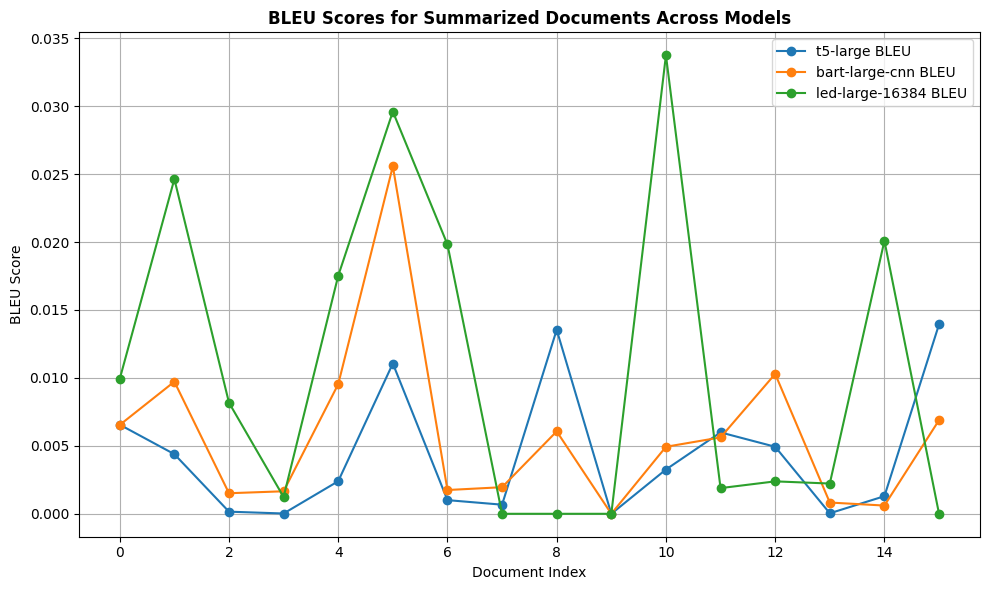

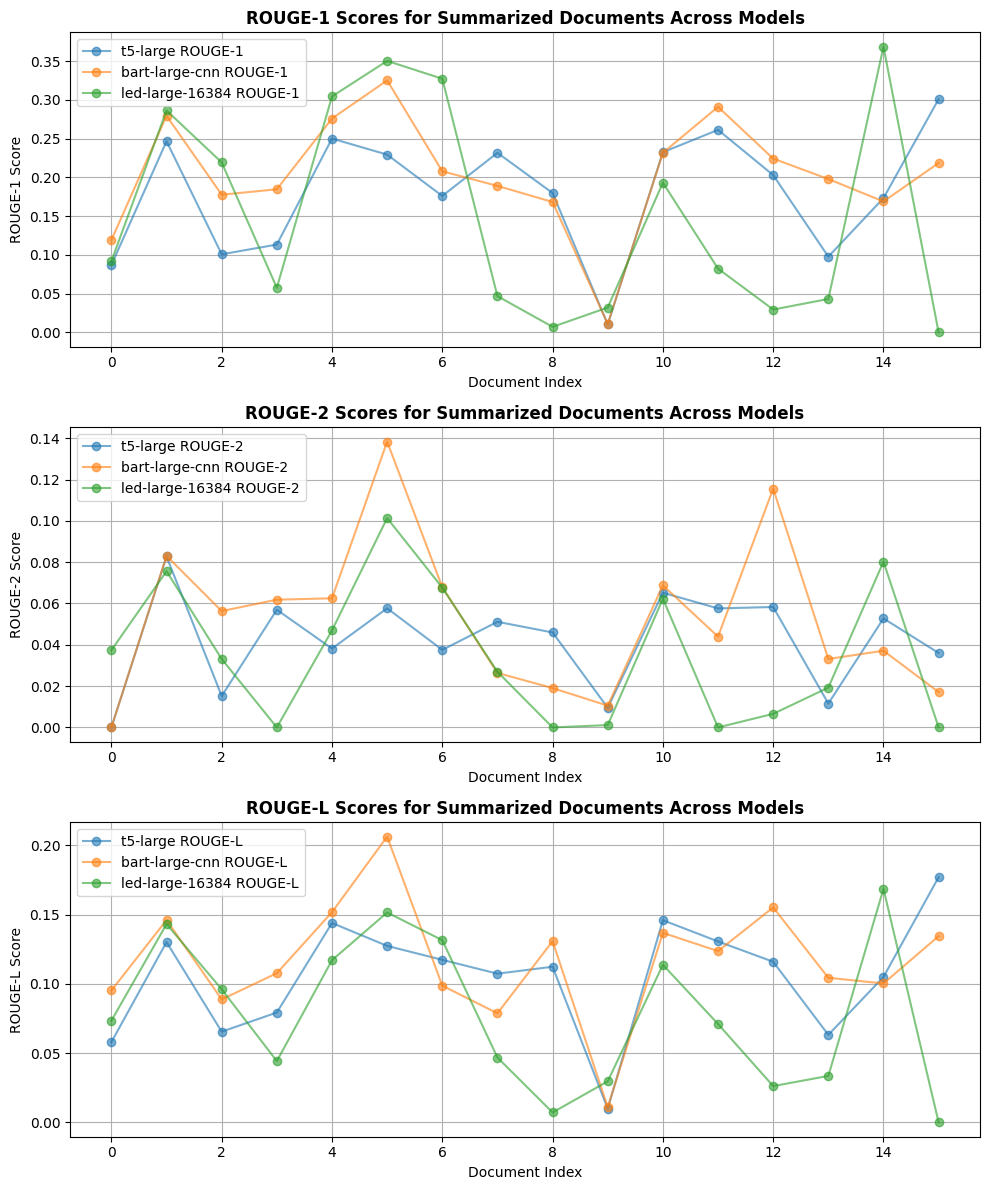


Validation Set Scores:
                         Model      BLEU   ROUGE-1   ROUGE-2   ROUGE-L
0         t5-large_num_beams_4  0.004328  0.180808  0.042278  0.105558
1   bart-large-cnn_num_beams_4  0.005843  0.204325  0.052606  0.116859
2  led-large-16384_num_beams_4  0.010703  0.152444  0.034912  0.078366


/home/skanda/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Evaluating with num_beams=2, length_penalty=0.8
Evaluating with num_beams=2, length_penalty=1.0
Evaluating with num_beams=2, length_penalty=1.2
Evaluating with num_beams=4, length_penalty=0.8
Evaluating with num_beams=4, length_penalty=1.0
Evaluating with num_beams=4, length_penalty=1.2
Evaluating with num_beams=6, length_penalty=0.8
Evaluating with num_beams=6, length_penalty=1.0
Evaluating with num_beams=6, length_penalty=1.2
Best configuration found: num_beams=6, length_penalty=1.2, with average score=0.0096
Error in generating summary: 'int' object has no attribute 'encode'
Error in generating summary: 'int' object has no attribute 'encode'
Error in generating summary: 'int' object has no attribute 'encode'
Error in generating summary: 'int' object has no attribute 'encode'
Error in generating summary: 'int' object has no attribute 'encode'
Error in generating summary: 'int' object has no attribute 'encode'
Error in generating summary: 'int' object has no attribute 'encode'
Error i

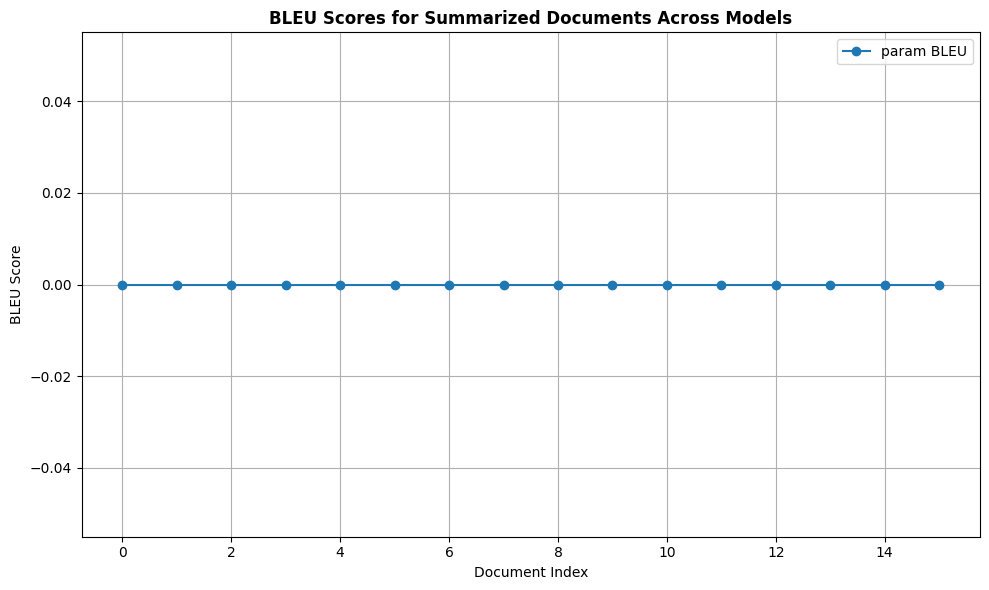

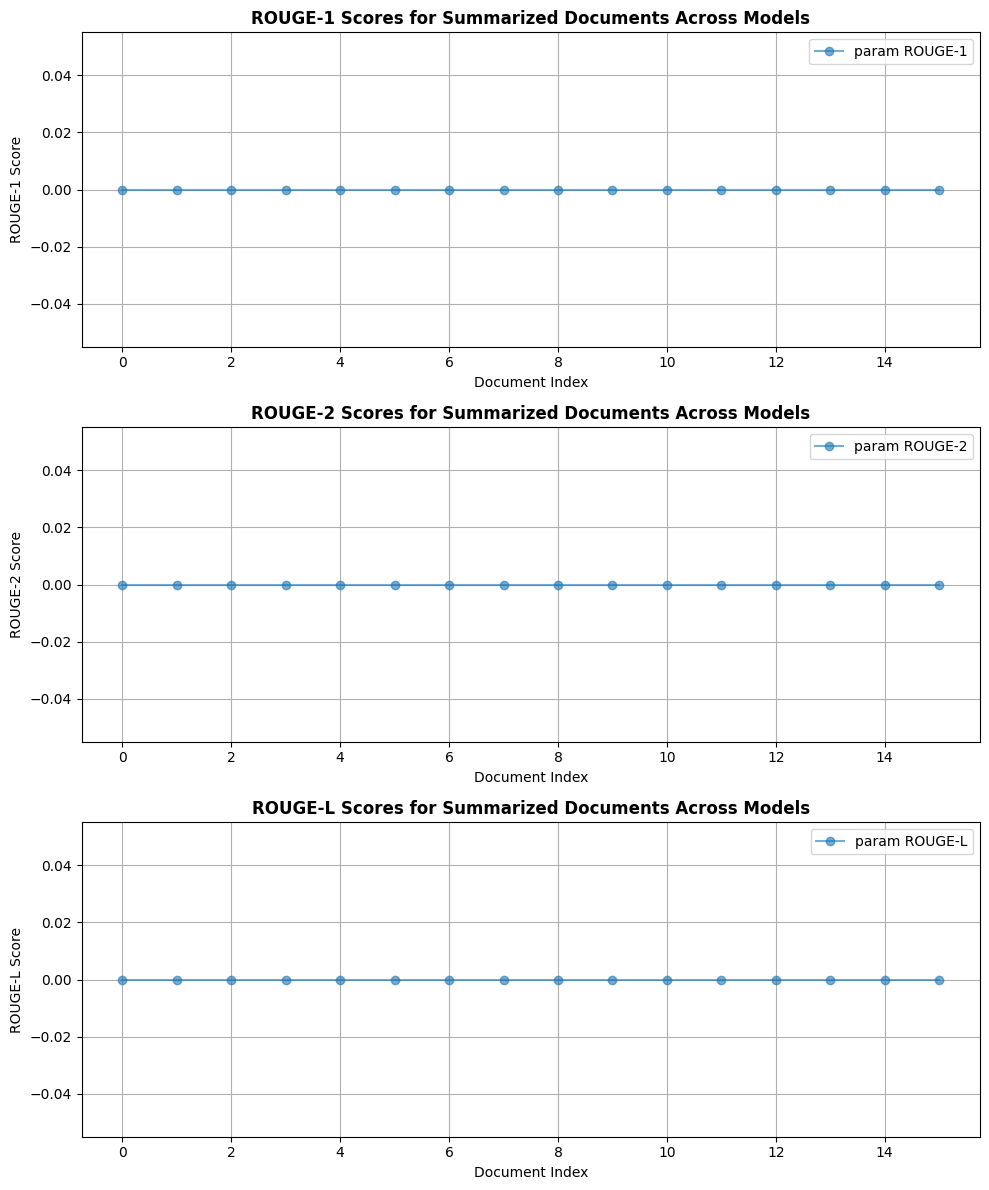

In [21]:
import pandas as pd

def main():
    # Define paths and parameters
    preprocessed_dir = '/mnt/scratch/skanda/MSc_IRD_LLM/data/data_separated'
    results_dir = "/mnt/scratch/skanda/MSc_IRD_LLM/results"
    model_names = ["t5-large", "bart-large-cnn", "led-large-16384"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Load dataset
    abstracts, main_texts, filenames = load_preprocessed_data(preprocessed_dir)

    # 2. Split data into training, validation, and test sets
    train_data, validation_data, test_data = split_data(abstracts, main_texts, filenames, test_size=0.33, val_size=0.5)
    train_abstracts, train_texts, train_filenames = zip(*train_data)
    validation_abstracts, validation_texts, validation_filenames = zip(*validation_data)
    test_abstracts, test_texts, test_filenames = zip(*test_data)

    print(f"Loaded {len(validation_abstracts)} abstracts and {len(validation_texts)} main texts for validation.")

    # 3. Evaluate models on the validation set
    model_scores_dict = evaluate_models(
        model_names=model_names,
        validation_abstracts=validation_abstracts,
        validation_texts=validation_texts,
        validation_filenames=validation_filenames,
        results_dir=results_dir,
        num_beams=4
    )

    # 4. Plot initial scores (Validation set results)
    plot_bleu_scores(model_scores_dict)
    plot_rouge_scores(model_scores_dict)

    # 5. Print validation set scores in a tabular format
    validation_scores_table = pd.DataFrame({
        'Model': list(model_scores_dict.keys()),
        'BLEU': [np.mean(scores[0]) for scores in model_scores_dict.values()],
        'ROUGE-1': [np.mean([score['rouge1'].fmeasure for score in scores[1]]) for scores in model_scores_dict.values()],
        'ROUGE-2': [np.mean([score['rouge2'].fmeasure for score in scores[1]]) for scores in model_scores_dict.values()],
        'ROUGE-L': [np.mean([score['rougeL'].fmeasure for score in scores[1]]) for scores in model_scores_dict.values()]
    })
    print("\nValidation Set Scores:")
    print(validation_scores_table)

    # 6. Select and fine-tune the best model based on the combined average score
    best_models = select_best_models(model_scores_dict)
    best_model_name, best_average_score = best_models['combined']

    param_tuned_model, fine_tuned_tokenizer, _ = tune_hyperparameters(
        best_model_name=best_model_name,
        train_texts=train_texts,  # Fine-tuning on training data
        validation_texts=validation_abstracts,  # Use validation abstracts as references
        device=device
    )

    # 7. Evaluate the fine-tuned model on the test set
    test_bleu_scores, test_rouge_scores_list = [], []
    num_beams = int(best_model_name.split('_')[-1])  # Correctly extract the number of beams
    for text, ref in zip(test_texts, test_abstracts):
        summary = generate_summary(
            model=param_tuned_model,
            tokenizer=fine_tuned_tokenizer,
            text=text,
            device=device,
            num_beams=num_beams,  # Use the correctly extracted number of beams
            length_penalty=1.0
        )
        bleu, rouge = evaluate_summary(ref, summary)
        test_bleu_scores.append(bleu)
        test_rouge_scores_list.append(rouge)

    # 8. Print test set scores in a tabular format
    test_scores_table = pd.DataFrame({
        'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Score': [
            np.mean(test_bleu_scores),
            np.mean([score['rouge1'].fmeasure for score in test_rouge_scores_list]),
            np.mean([score['rouge2'].fmeasure for score in test_rouge_scores_list]),
            np.mean([score['rougeL'].fmeasure for score in test_rouge_scores_list])
        ]
    })
    print("\nTest Set Scores:")
    print(test_scores_table)

    # 9. Save the results for the test set
    param_tuned_results_dir = os.path.join(results_dir, best_model_name.replace("/", "_") + "_fine_tuned_test")
    save_results(test_texts, test_bleu_scores, test_rouge_scores_list, test_filenames, param_tuned_results_dir)

    # 10. Visualize the test set results
    plot_bleu_scores({'param_tuned_model': (test_bleu_scores, test_rouge_scores_list)})
    plot_rouge_scores({'param_tuned_model': (test_bleu_scores, test_rouge_scores_list)})

if __name__ == "__main__":
    main()


In [22]:
""" 
def plot_entity_scores(model_scores_dict):
    plt.figure(figsize=(20, 10))
    
    for model_name, (_, _, entity_comparisons) in model_scores_dict.items():
        f1_scores = [comp['f1'] for comp in entity_comparisons]
        
        plt.plot(range(len(f1_scores)), f1_scores, marker='o', linestyle='-', label=f'{model_name} Entity F1')
    
    plt.xlabel('Document Index')
    plt.ylabel('Entity F1 Score')
    plt.title('Entity F1 Scores for Summarized Documents Across Models', fontweight='bold')
    plt.grid(True)
    # plt.legend()
    plt.tight_layout()
    plt.show()

def plot_entity_metrics(model_scores_dict):
    plt.figure(figsize=(20, 15))
    
    metrics = ['precision', 'recall', 'f1']
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 1, i)
        for model_name, (_, _, entity_comparisons) in model_scores_dict.items():
            scores = [comp[metric] for comp in entity_comparisons]
            plt.plot(range(len(scores)), scores, marker='o', linestyle='-', label=f'{model_name}')
        
        plt.xlabel('Document Index')
        plt.ylabel(f'Entity {metric.capitalize()}')
        plt.title(f'Entity {metric.capitalize()} Scores Across Models', fontweight='bold')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def analyze_entity_coverage(model_scores_dict):
    for model_name, (_, _, entity_comparisons) in model_scores_dict.items():
        common_entities = set.intersection(*[set(comp['common_entities']) for comp in entity_comparisons])
        all_missed = set.union(*[set(comp['missed_entities']) for comp in entity_comparisons])
        all_extra = set.union(*[set(comp['extra_entities']) for comp in entity_comparisons])
        
        print(f"\nAnalysis for {model_name}:")
        print(f"Number of entities common across all documents: {len(common_entities)}")
        print(f"Total number of unique missed entities: {len(all_missed)}")
        print(f"Total number of unique extra entities: {len(all_extra)}")
        
        if len(common_entities) > 0:
            print("Sample of common entities:", list(common_entities)[:5])
        if len(all_missed) > 0:
            print("Sample of missed entities:", list(all_missed)[:5])
        if len(all_extra) > 0:
            print("Sample of extra entities:", list(all_extra)[:5])

# After your main execution loop
print("\nPlotting Entity F1 Scores...")
plot_entity_scores(model_scores_dict)

print("\nPlotting Detailed Entity Metrics...")
plot_entity_metrics(model_scores_dict)

print("\nAnalyzing Entity Coverage...")
analyze_entity_coverage(model_scores_dict)
"""

' \ndef plot_entity_scores(model_scores_dict):\n    plt.figure(figsize=(20, 10))\n    \n    for model_name, (_, _, entity_comparisons) in model_scores_dict.items():\n        f1_scores = [comp[\'f1\'] for comp in entity_comparisons]\n        \n        plt.plot(range(len(f1_scores)), f1_scores, marker=\'o\', linestyle=\'-\', label=f\'{model_name} Entity F1\')\n    \n    plt.xlabel(\'Document Index\')\n    plt.ylabel(\'Entity F1 Score\')\n    plt.title(\'Entity F1 Scores for Summarized Documents Across Models\', fontweight=\'bold\')\n    plt.grid(True)\n    # plt.legend()\n    plt.tight_layout()\n    plt.show()\n\ndef plot_entity_metrics(model_scores_dict):\n    plt.figure(figsize=(20, 15))\n    \n    metrics = [\'precision\', \'recall\', \'f1\']\n    \n    for i, metric in enumerate(metrics, 1):\n        plt.subplot(3, 1, i)\n        for model_name, (_, _, entity_comparisons) in model_scores_dict.items():\n            scores = [comp[metric] for comp in entity_comparisons]\n            pl